In [424]:
import os
import re
import keras
import urllib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import OrderedDict, Counter

from keras import metrics
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set_style('white')
plt.style.use('bmh')

## Downloading images, converting them to numpy arrays

In [332]:
df = pd.read_json('data/themoviedb-sample-4-17-2017.json')
df = df[df['poster_path'].isnull() == False]
df['poster_url'] = df['poster_path'].apply(lambda x: 'http://image.tmdb.org/t/p/w92{}'.format(x))
df = df[['title', 'genre', 'poster_url']]
print(df.shape)
df.head()

(9175, 3)


,title,genre,poster_url
0,Bought,Documentary,http://image.tmdb.org/t/p/w92/5q3CQLHMbvsjxK4V...
1,Egypt Underworld,Documentary,http://image.tmdb.org/t/p/w92/vHZf7KA7RGMxWl2r...
2,Chinese Heroes,Action,http://image.tmdb.org/t/p/w92/74F1NxjpQFoXoJzG...
3,Shakedown,Action,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...
4,Shakedown,Drama,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...


#### Downloading all the posters
Here, we download them at the smallest size (width = 92 pixels). 

In [333]:
for url in df['poster_url'].unique():
    file_name = re.findall(r'(?<=w92\/)(.*)', url)[0]
    if file_name not in os.listdir('data/img'):
        urllib.urlretrieve(url, 'data/img/{}'.format(file_name))

#### Flattening into numpy arrays
Resizing images to `(138, 92, 3)`. We expect this will lose us some precision later.

In [330]:
images = []
y = []

for image_file in os.listdir('data/img'):
    img = load_img('data/img/{}'.format(image_file))
    images.append(np.resize(img_to_array(img),(138,92,3)))
    y.append(np.array([x for x in df[df['poster_url'] == 'http://image.tmdb.org/t/p/w92/{}'.format(image_file)]['genre'].values]))

## $y$: Multi-label

In [6]:
y[0:5]

[array([u'Drama', u'Comedy', u'Crime'], 
       dtype='<U6'), array([u'Action', u'Adventure'], 
       dtype='<U9'), array([u'Drama', u'Comedy'], 
       dtype='<U6'), array([u'Documentary', u'Music'], 
       dtype='<U11'), array([u'Adventure', u'Western'], 
       dtype='<U9')]

In [335]:
X = np.array(images)
# Normalizing away from 255
X = X / 255.
input_shape = X.shape
print(input_shape)

(4722, 138, 92, 3)


In [381]:
all_genres = pd.DataFrame(index = range(0,4722))

for row in y:
    for genre in row:
        if genre in all_genres:
            pass
        else:
            all_genres[genre] = 0

for index, row in enumerate(y):
    for genre in row:
        all_genres[genre].loc[index] = 1
        
print(all_genres.shape)
all_genres.head()

(4722, 20)


,Drama,Comedy,Crime,Action,Adventure,Documentary,Music,Western,Horror,Animation,Family,Thriller,Mystery,Science Fiction,History,TV Movie,Romance,Foreign,War,Fantasy
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [337]:
Y = np.array(all_genres)
print(Y.shape)

(4722, 20)


#### Fitting a simple CNN model

In [12]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# # --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.5))
# --- Last layer: classification ---
model.add(Dense(20, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 137, 91, 80)       1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 68, 45, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 43, 100)       72100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 21, 100)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 19, 100)       90100     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 9, 100)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 9, 100)        0         
__________

In [21]:
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', 'categorical_accuracy'])

In [371]:
batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Fit model on training data
history = model.fit(X, Y,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1)


Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 352s - loss: 5.2638 - acc: 0.3092 - val_loss: 5.1852 - val_acc: 0.3693
Epoch 2/5
3777/3777 [==============================] - 355s - loss: 5.1863 - acc: 0.3566 - val_loss: 5.1688 - val_acc: 0.3693
Epoch 3/5
3777/3777 [==============================] - 361s - loss: 5.1794 - acc: 0.3564 - val_loss: 5.1715 - val_acc: 0.3693
Epoch 4/5
3777/3777 [==============================] - 374s - loss: 5.1525 - acc: 0.3564 - val_loss: 5.1092 - val_acc: 0.3693
Epoch 5/5
3777/3777 [==============================] - 362s - loss: 5.1061 - acc: 0.3561 - val_loss: 5.1115 - val_acc: 0.3693


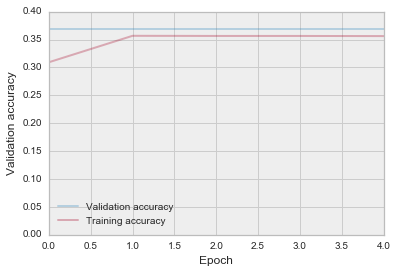

In [376]:
plt.plot(history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,0.4])
plt.legend(loc = 'best')
plt.show()

In [377]:
# Predicted lables per movie
preds = model.predict(X)
Y[0], preds[0]

(array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.98346633,  0.85274035,  0.19254753,  0.34592992,  0.23179571,
         0.53864813,  0.1653022 ,  0.049001  ,  0.26795316,  0.28179586,
         0.40311366,  0.3431938 ,  0.0851384 ,  0.23508087,  0.08581931,
         0.11504664,  0.34762105,  0.05560172,  0.04429831,  0.14693935], dtype=float32))

In [383]:
# Precision and Recall
# --Precision: number of true positives over the number of true positives plus the number of false positives
# --Recall: number of true positives over the number of true positives plus the number of false negatives
precision = dict()
average_precision = dict()
recall_score = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        preds[:, i])
    average_precision[i] = average_precision_score(Y[:, i], preds[:, i])
    recall_score[i] = recall[i].mean()

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
average_precision_np = pd.DataFrame(np.array(average_precision.items(), dtype=dtype))
average_precision_np['genre'] = list(all_genres.columns.values)
recall_score_np = pd.DataFrame(np.array(recall_score.items(), dtype=dtype))
recall_score_np['genre'] = list(all_genres.columns.values)

In [384]:
# Sort genres by precision and recall
average_precision_np = average_precision_np.sort_values(by = 'data', ascending=[0])
recall_score_np = recall_score_np.sort_values(by = 'data', ascending=[0])

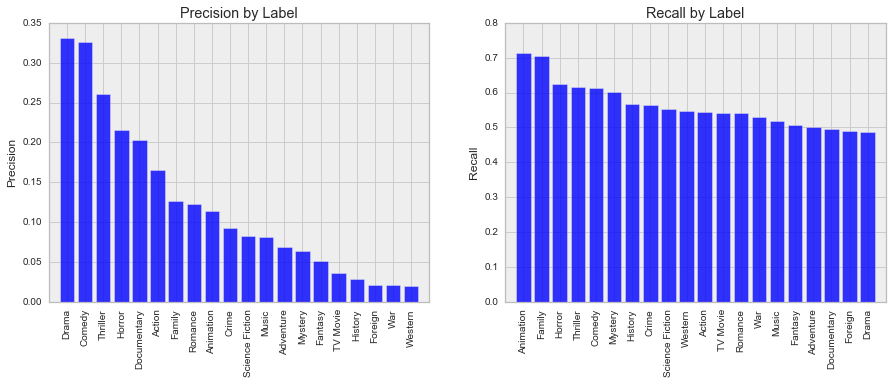

In [385]:
# Plot precision and recall
y_pos = np.arange(len(average_precision_np.genre)) + 1

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

ax1 = plt.bar(y_pos, average_precision_np.data, align='center', alpha=0.8, color='b')
ax1 = plt.xticks(y_pos, average_precision_np.genre, rotation=90)
ax1 = plt.xlim([0,21])
ax1 = plt.ylabel('Precision')
ax1 = plt.title('Precision by Label')

ax2 = fig.add_subplot(1, 2, 2)

ax2 = plt.bar(y_pos, recall_score_np.data, align='center', alpha=0.8, color='b')
ax2 = plt.xticks(y_pos, recall_score_np.genre, rotation=90)
ax2 = plt.xlim([0,21])
ax2 = plt.ylabel('Recall')
ax2 = plt.title('Recall by Label')

plt.show()

## $y$: Most popular single genre

In [386]:
y[0:5]

[array([u'Drama', u'Comedy', u'Crime'], 
       dtype='<U6'), array([u'Action', u'Adventure'], 
       dtype='<U9'), array([u'Drama', u'Comedy'], 
       dtype='<U6'), array([u'Documentary', u'Music'], 
       dtype='<U11'), array([u'Adventure', u'Western'], 
       dtype='<U9')]

In [339]:
all_genres = [list(x) for x in y]
all_genres_list = [item for sublist in all_genres for item in sublist]
print(len(all_genres_list))
all_genres[0:5]

9175


[[u'Drama', u'Comedy', u'Crime'],
 [u'Action', u'Adventure'],
 [u'Drama', u'Comedy'],
 [u'Documentary', u'Music'],
 [u'Adventure', u'Western']]

In [340]:
top_genres = Counter(all_genres_list).most_common(20)
new_y = []

for row in y:
    new_row_genre = 'other'
    for genre in row:
        if new_row_genre == 'other' and genre in OrderedDict(top_genres):
            new_row_genre = genre
        else:
            pass
    new_y.append(new_row_genre)


y[0], new_y[0]

(array([u'Drama', u'Comedy', u'Crime'], 
       dtype='<U6'), u'Drama')

In [411]:
# Define y as multi-class (i.e. only one genre per movie - most popular)
encoder = LabelEncoder()
encoder.fit(new_y)
encoded_Y = encoder.transform(new_y)
# convert integers to dummy variables (i.e. one hot encoded)
Y_new = np_utils.to_categorical(encoded_Y)

In [414]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# # --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.5))

# --- Last layer: classification ---
model.add(Dense(20, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 137, 91, 80)       1040      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 68, 45, 80)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 66, 43, 100)       72100     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 33, 21, 100)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 31, 19, 100)       90100     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 15, 9, 100)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 9, 100)        0         
__________

In [415]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Multi-class prediction: single genre!
new_history = model.fit(X, Y_new,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1)

Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 351s - loss: 2.5527 - acc: 0.1914 - val_loss: 2.4329 - val_acc: 0.2233
Epoch 2/5
3777/3777 [==============================] - 388s - loss: 2.4806 - acc: 0.2065 - val_loss: 2.4373 - val_acc: 0.2233
Epoch 3/5
3777/3777 [==============================] - 412s - loss: 2.4656 - acc: 0.2092 - val_loss: 2.4336 - val_acc: 0.2233
Epoch 4/5
3777/3777 [==============================] - 368s - loss: 2.4603 - acc: 0.2089 - val_loss: 2.4257 - val_acc: 0.2233
Epoch 5/5
3777/3777 [==============================] - 375s - loss: 2.4572 - acc: 0.2126 - val_loss: 2.4250 - val_acc: 0.2233


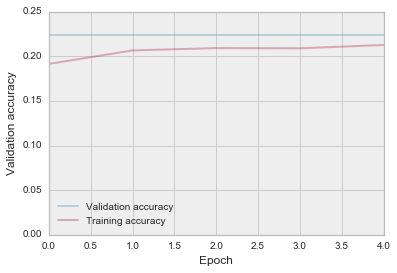

In [416]:
# Our network is underfitting the data
plt.plot(new_history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(new_history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,0.25])
plt.legend(loc = 'best')
plt.show()

In [426]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# What i do is pick the majority class as a reference and assign weights for 
# the other classes based on the reference class. So if you have 3 classes with classA:10%, 
# classB:50% and classC:40% then you get the weights: {0:5, 1:1, 2:1.25}

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

class_weight = get_class_weights(pd.DataFrame(Y_new))

# Multi-class prediction: single genre!
new_history = model.fit(X, Y_new,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1,
                    class_weight = class_weight)

Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 351s - loss: 2.4631 - acc: 0.2097 - val_loss: 2.4290 - val_acc: 0.2233
Epoch 2/5
3777/3777 [==============================] - 366s - loss: 2.4556 - acc: 0.2100 - val_loss: 2.4250 - val_acc: 0.2233
Epoch 3/5
3777/3777 [==============================] - 346s - loss: 2.4517 - acc: 0.2129 - val_loss: 2.4239 - val_acc: 0.2233
Epoch 4/5
3777/3777 [==============================] - 347s - loss: 2.4500 - acc: 0.2129 - val_loss: 2.4243 - val_acc: 0.2233
Epoch 5/5
3777/3777 [==============================] - 367s - loss: 2.4500 - acc: 0.2100 - val_loss: 2.4248 - val_acc: 0.2233


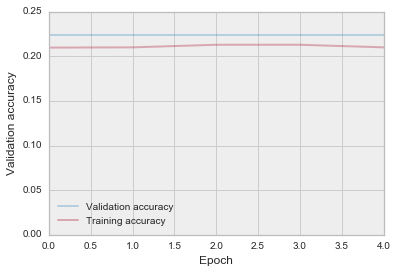

In [427]:
# With class weights
plt.plot(new_history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(new_history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,0.25])
plt.legend(loc = 'best')
plt.show()

In [428]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(138,92,3)))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(20, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 67, 44, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 65, 42, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 21, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 21504)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                1376320   
_________________________________________________________________
dense_22 (Dense)             (None, 20)                1300      
Total para

In [429]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Multi-class prediction: single genre!
new_history = model.fit(X, Y_new,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1,
                    class_weight = class_weight)

Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 84s - loss: 2.5311 - acc: 0.1935 - val_loss: 2.4807 - val_acc: 0.1534
Epoch 2/5
3777/3777 [==============================] - 87s - loss: 2.4799 - acc: 0.2023 - val_loss: 2.4341 - val_acc: 0.1534
Epoch 3/5
3777/3777 [==============================] - 83s - loss: 2.4643 - acc: 0.2081 - val_loss: 2.4279 - val_acc: 0.2180
Epoch 4/5
3777/3777 [==============================] - 88s - loss: 2.4377 - acc: 0.2145 - val_loss: 2.4050 - val_acc: 0.2222
Epoch 5/5
3777/3777 [==============================] - 85s - loss: 2.4145 - acc: 0.2250 - val_loss: 2.4060 - val_acc: 0.2042


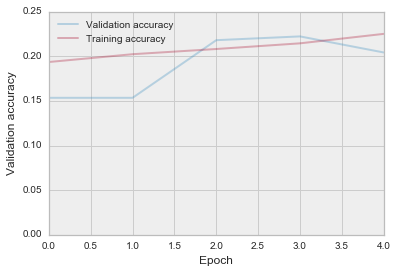

In [430]:
# With class weights
plt.plot(new_history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(new_history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,0.25])
plt.legend(loc = 'best')
plt.show()

In [431]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Math.log smooths the weights for very imbalanced classes

def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

labels_tot = Y_new.sum(axis=0)

labels_dict = dict(enumerate(labels_tot))
class_weight = create_class_weight(labels_dict)

# Multi-class prediction: single genre!
new_history = model.fit(X, Y_new,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1,
                    class_weight = class_weight)

Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 87s - loss: 3.3071 - acc: 0.2205 - val_loss: 3.2568 - val_acc: 0.2243
Epoch 2/5
3777/3777 [==============================] - 86s - loss: 3.2556 - acc: 0.2160 - val_loss: 3.3107 - val_acc: 0.1989
Epoch 3/5
3777/3777 [==============================] - 97s - loss: 3.1696 - acc: 0.2272 - val_loss: 3.2977 - val_acc: 0.2085
Epoch 4/5
3777/3777 [==============================] - 91s - loss: 2.9605 - acc: 0.2600 - val_loss: 3.5055 - val_acc: 0.1683
Epoch 5/5
3777/3777 [==============================] - 96s - loss: 2.6019 - acc: 0.3357 - val_loss: 3.8482 - val_acc: 0.1492


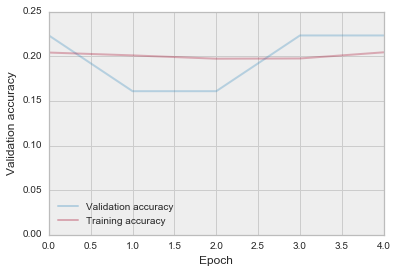

In [410]:
# Our network is underfitting the data
plt.plot(new_history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(new_history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,0.25])
plt.legend(loc = 'best')
plt.show()